In [1]:

import os

import keras
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import layers
from keras import models

os.environ["TF_USE_LEGACY_KERAS"] = "1"

## Load dataset

In [2]:
(ds_train, ds_validation, ds_test), metadata  = tfds.load(
    "tf_flowers",
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    as_supervised=True,
    with_info=True
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
metadata

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/incomplete.Y74SL4_3.0.1/',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [4]:
print(metadata.splits["train"].num_examples)
num_classes = metadata.features["label"].num_classes
labels = metadata.features["label"].names
print(num_classes)
print(labels)

3670
5
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


## Visualize a few images

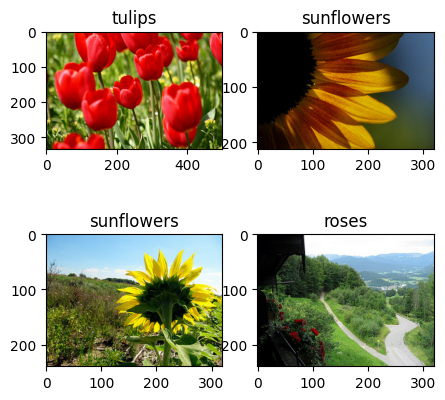

In [5]:

samples = ds_train.take(4)
fig = plt.figure(figsize=(5, 5))
for i,img in enumerate(tfds.as_numpy(samples)):
    img_array, img_label_idx = img
    ax = fig.add_subplot(2,2, i + 1)
    ax.imshow(img_array)
    ax.set_title(labels[img_label_idx])
plt.show()

## Prepare dataset for training

In [6]:
IMG_SIZE = 180

resize_and_rescale = models.Sequential([
    layers.Resizing(IMG_SIZE,IMG_SIZE),
    layers.Rescaling(1./255)
])

data_augmentation = models.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1)
])

def prepare_for_training(ds_subset, batch_size = 32, shuffle=False, augment=False):
    ds_subset  =  ds_subset.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # shuffle the dataset if needed
    if shuffle:
        ds_subset = ds_subset.shuffle(1000)

    # create data batches
    ds_subset = ds_subset.batch(batch_size)

    # apply data augmentation
    if augment:
        ds_subset= ds_subset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Use buffered prefecting on all datasets
    return ds_subset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


transformed_ds_train = prepare_for_training(ds_train, shuffle=True, augment=True)
transformed_ds_val = prepare_for_training(ds_validation)
transformed_ds_test = prepare_for_training(ds_test)

### Check how the images look like after processing

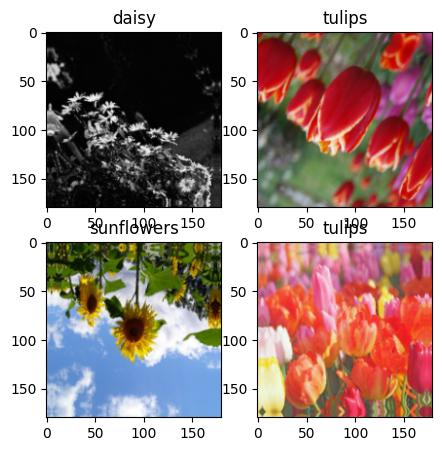

In [7]:
samples = transformed_ds_train.take(4)
fig = plt.figure(figsize=(5, 5))
for i,img in enumerate(tfds.as_numpy(samples)):
    batch_images, batch_labels = img
    #print(np.min(img_array), np.max(img_array))
    ax = fig.add_subplot(2,2, i + 1)
    ax.imshow(batch_images[0])
    ax.set_title(labels[batch_labels[0]])
plt.show()

### Create model

In [8]:
model = models.Sequential([
  layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="input"),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [9]:

model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train model and visualize training history

In [10]:
epochs=20
history = model.fit(transformed_ds_train,validation_data=transformed_ds_val, epochs=epochs)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.3755 - loss: 1.4084 - val_accuracy: 0.5477 - val_loss: 1.2010
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5579 - loss: 1.0735 - val_accuracy: 0.6076 - val_loss: 1.0159
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6080 - loss: 0.9847 - val_accuracy: 0.6431 - val_loss: 0.9958
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6538 - loss: 0.9110 - val_accuracy: 0.6540 - val_loss: 0.8903
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6556 - loss: 0.8759 - val_accuracy: 0.6812 - val_loss: 0.8442
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6904 - loss: 0.8318 - val_accuracy: 0.6458 - val_loss: 0.9889
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6979 - loss: 0.7886 - val_accuracy: 0.6975 - val_loss: 0.7817
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7069 - loss: 0.7345 - val_accuracy: 0.6894 -

In [11]:
history_dict = history.history
val_acc_values = history_dict['val_accuracy']
train_acc_values = history_dict['accuracy']
val_loss_values = history_dict['val_loss']
train_loss_values = history_dict['loss']
epochs_range = range(epochs)


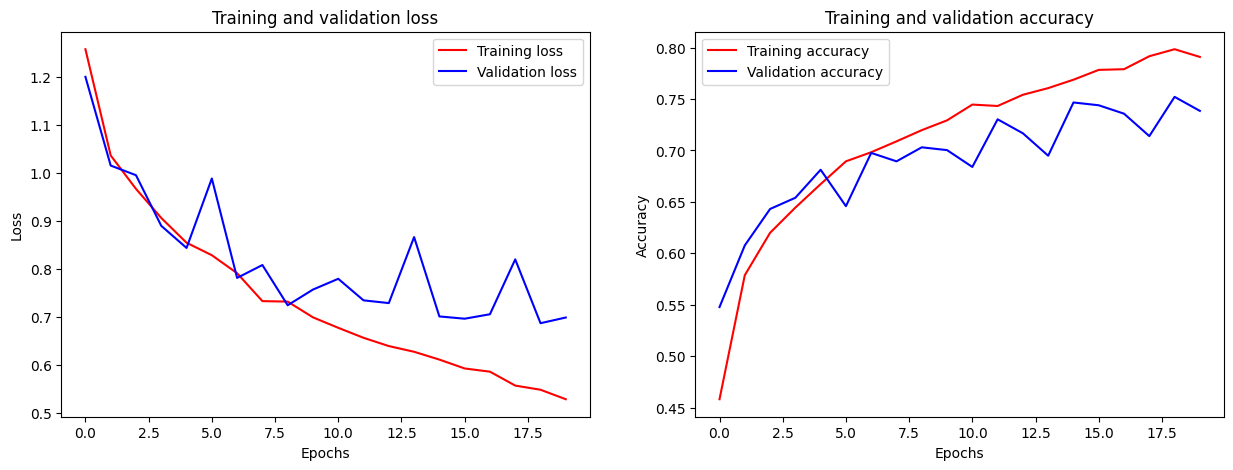

In [12]:
## Plotting the training and validation loss

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_values, 'r', label='Training loss')
plt.plot(epochs_range, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Plotting the training and validation accuracy

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_values, 'r', label='Training accuracy')
plt.plot(epochs_range, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Generic Metrics

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


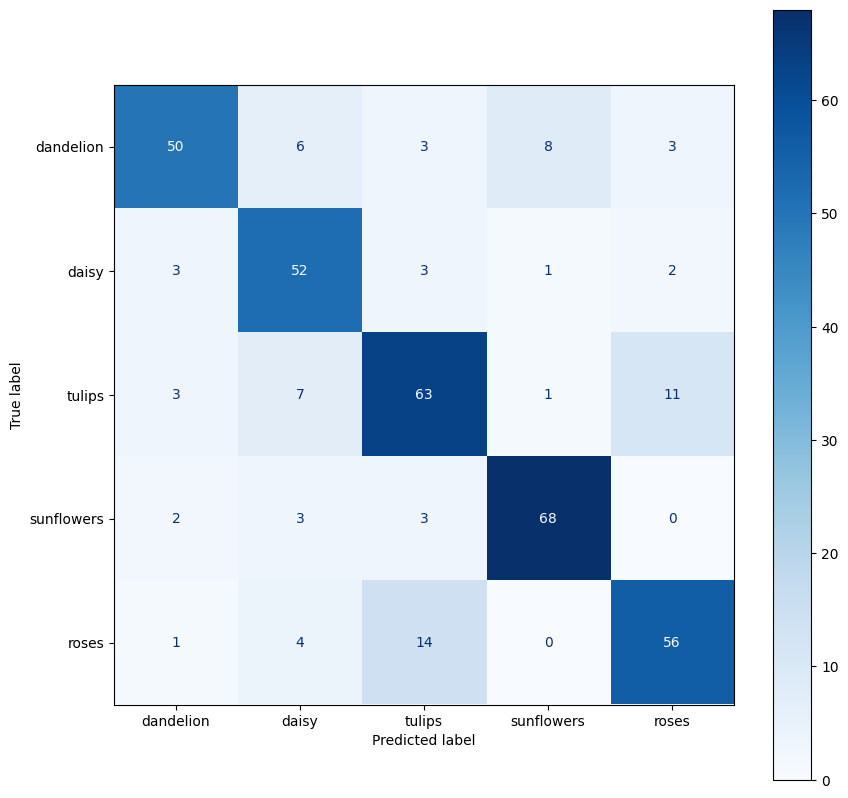

In [13]:
## create confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y = [labels for imgs, labels in tfds.as_numpy(transformed_ds_test.unbatch())]
y_pred_probs = model.predict(transformed_ds_test)
y_pred = np.argmax(y_pred_probs, axis=1)


fig, _ = plt.subplots(nrows=1, figsize=(10,10))
ax = plt.subplot(1, 1, 1)
ax.grid(False)
cf = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)
plt.show()

### Inspect model parameters

Inspect the model parameters and see how many parameters are there in the model.


In [14]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,967,857 (45.65 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,978,572 (30.44 MB)

### Inspect learned features

In [15]:

image_url = "https://static.wixstatic.com/media/e6591e_3a5449fe774a4993a1166b1d33e233f7~mv2_d_1880_1253_s_2.jpg/v1/fill/w_1000,h_666,al_c,q_90,usm_0.66_1.00_0.01/e6591e_3a5449fe774a4993a1166b1d33e233f7~mv2_d_1880_1253_s_2.jpg"
image_path = tf.keras.utils.get_file("image_test", image_url)
img = keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))

121362/121362 [==============================] - 0s 0us/step


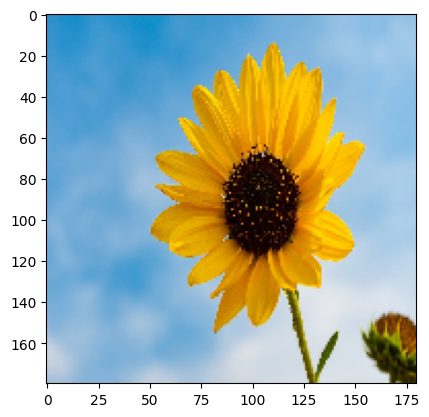

In [16]:
plt.imshow(img)

In [17]:
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_tensor = tf.convert_to_tensor(img_array)
img_tensor = tf.expand_dims(img_tensor, 0)
img_tensor = tf.divide(img_tensor, 255.0)
scores = model(img_tensor)
probs = tf.nn.softmax(scores).numpy().squeeze()
class_idx = np.argmax(probs)
print(f"this image was classified as {labels[class_idx]} with a probability of {probs[class_idx]}")

this image was classified as sunflowers with a probability of 0.9981638789176941


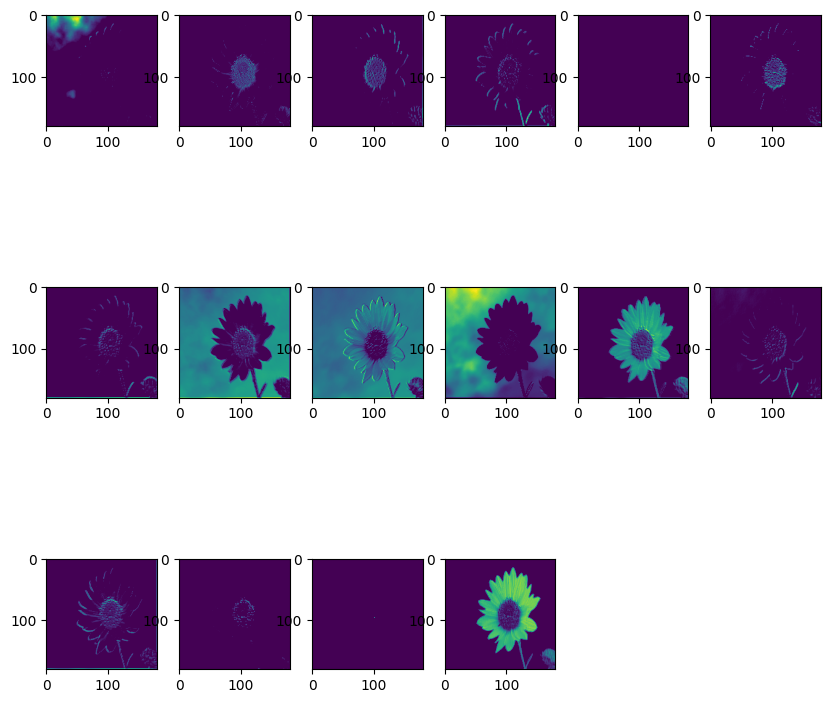

In [18]:
import math
cnn_layers = [layer for layer in model.layers  if isinstance(layer, layers.Conv2D)]
selected_layers = cnn_layers[:1]
features_extraction_model = models.Sequential(selected_layers)
features_map = features_extraction_model(img_tensor).numpy().squeeze()
num_fmaps = features_map.shape[-1]
num_rows = math.ceil(num_fmaps / 6)
fig = plt.figure(figsize=(10,10))
for i, fmap in enumerate(np.rollaxis(features_map, axis=2)):
    ax = fig.add_subplot(num_rows, 6, i + 1)
    ax.grid(False)
    ax.imshow(fmap, cmap='viridis')
plt.show()

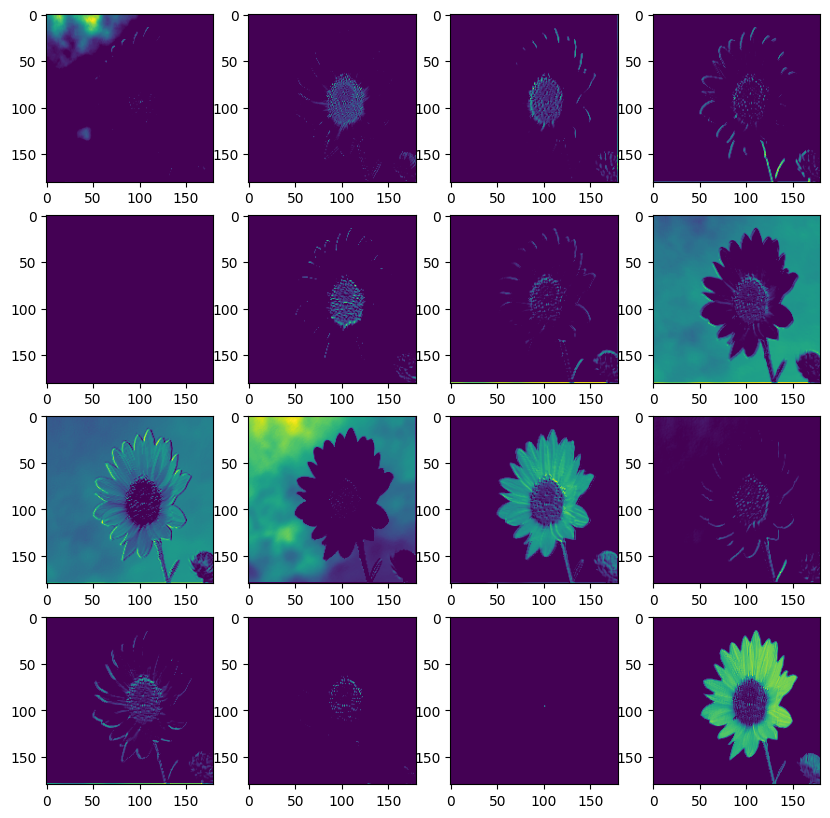

In [21]:
cnn_layer  = model.get_layer("conv2d")
features_map = cnn_layer(img_tensor)
features_map = features_map.numpy().squeeze()
fig = plt.figure(figsize=(10,10))
for i, fmap in enumerate(np.rollaxis(features_map, axis=2)):
    ax = fig.add_subplot(4,4, i + 1)
    ax.grid(False)
    ax.imshow(fmap, cmap='viridis')
plt.show()

### Save model

In [22]:
from pathlib import Path
MODELS_DIR = Path("models/flowers-model")
MODELS_DIR.mkdir(exist_ok=True, parents=True)
TF_MODEL_PATH = MODELS_DIR.joinpath("model.keras")

In [23]:
model.save(TF_MODEL_PATH)